# Example notebook

In this Jupyter Notebook, we showcase an example of usage of the **hyperFA*IR** package.

To analyze fairness in your rankings, you first need to load your data. The most stratight forward way is to load it from a Pandas DataFrame, and the package provides the [`load_data_from_pandas_df`](code/data_loader.py) function for this purpose. This function extracts the relevant ranking and protected attribute information from your DataFrame and prepares it for fairness analysis.

First, let us upload our data as a pandas DataFrame:

In [1]:
# Import necessary libraries
from hyperfair.data_loader import load_data_from_pandas_df
from hyperfair.hyperfair import measure_fairness_single_point, measure_fairness_multiple_points, adjust_ranking
from hyperfair.plotting import plot_ranking, plot_only_ci
import pandas as pd

# Load the data
COHORT_PATH = "./data/cohort.csv"
df_cohort = pd.read_csv(COHORT_PATH)
df_cohort.head()

,ID,SES,Score
0,0,Low SES,4.83
1,1,High SES,6.87
2,2,High SES,7.84
3,3,High SES,4.17
4,4,High SES,4.71


In this example, the DataFrame represents a modified version of the data used in Section 3.5 of the hyperFA*IR paper as cohort (a). Specifically, it contains academic scores from an elite university that admitted a high number of low-income students through a government scholarship program. The DataFrame includes three columns:
- **ID**: The unique identifier for each student (equal to the index in this case).
- **SES**: The socioeconomic status of the student, classified as "Low SES" (protected group) or "High SES".
- **Score**: The academic score of the student (e.g., GPA), which is used to rank the students.

Our goal is to analyze the fairness of a ranking based on the "Score" column, with respect to the "SES" attribute. To extract the ranking and protected group information, we use:

In [2]:
x, ids = load_data_from_pandas_df(
    df_cohort,
    protected_attribute='SES',
    binary_dict={'Low SES': 1, 'High SES': 0}, # Binary encoding for the protected attribute
    id_attribute='ID',
    order_by='Score',
    ascending=False  # Set to True if higher scores are better
)

print("Cohort loaded")
print(f"The length of the ranking is {len(x)}, and it contains {sum(x)} protected items.")

Cohort loaded
The length of the ranking is 47, and it contains 26 protected items.


Let us plot the proportion of protected candidates for each top % of the ranking.

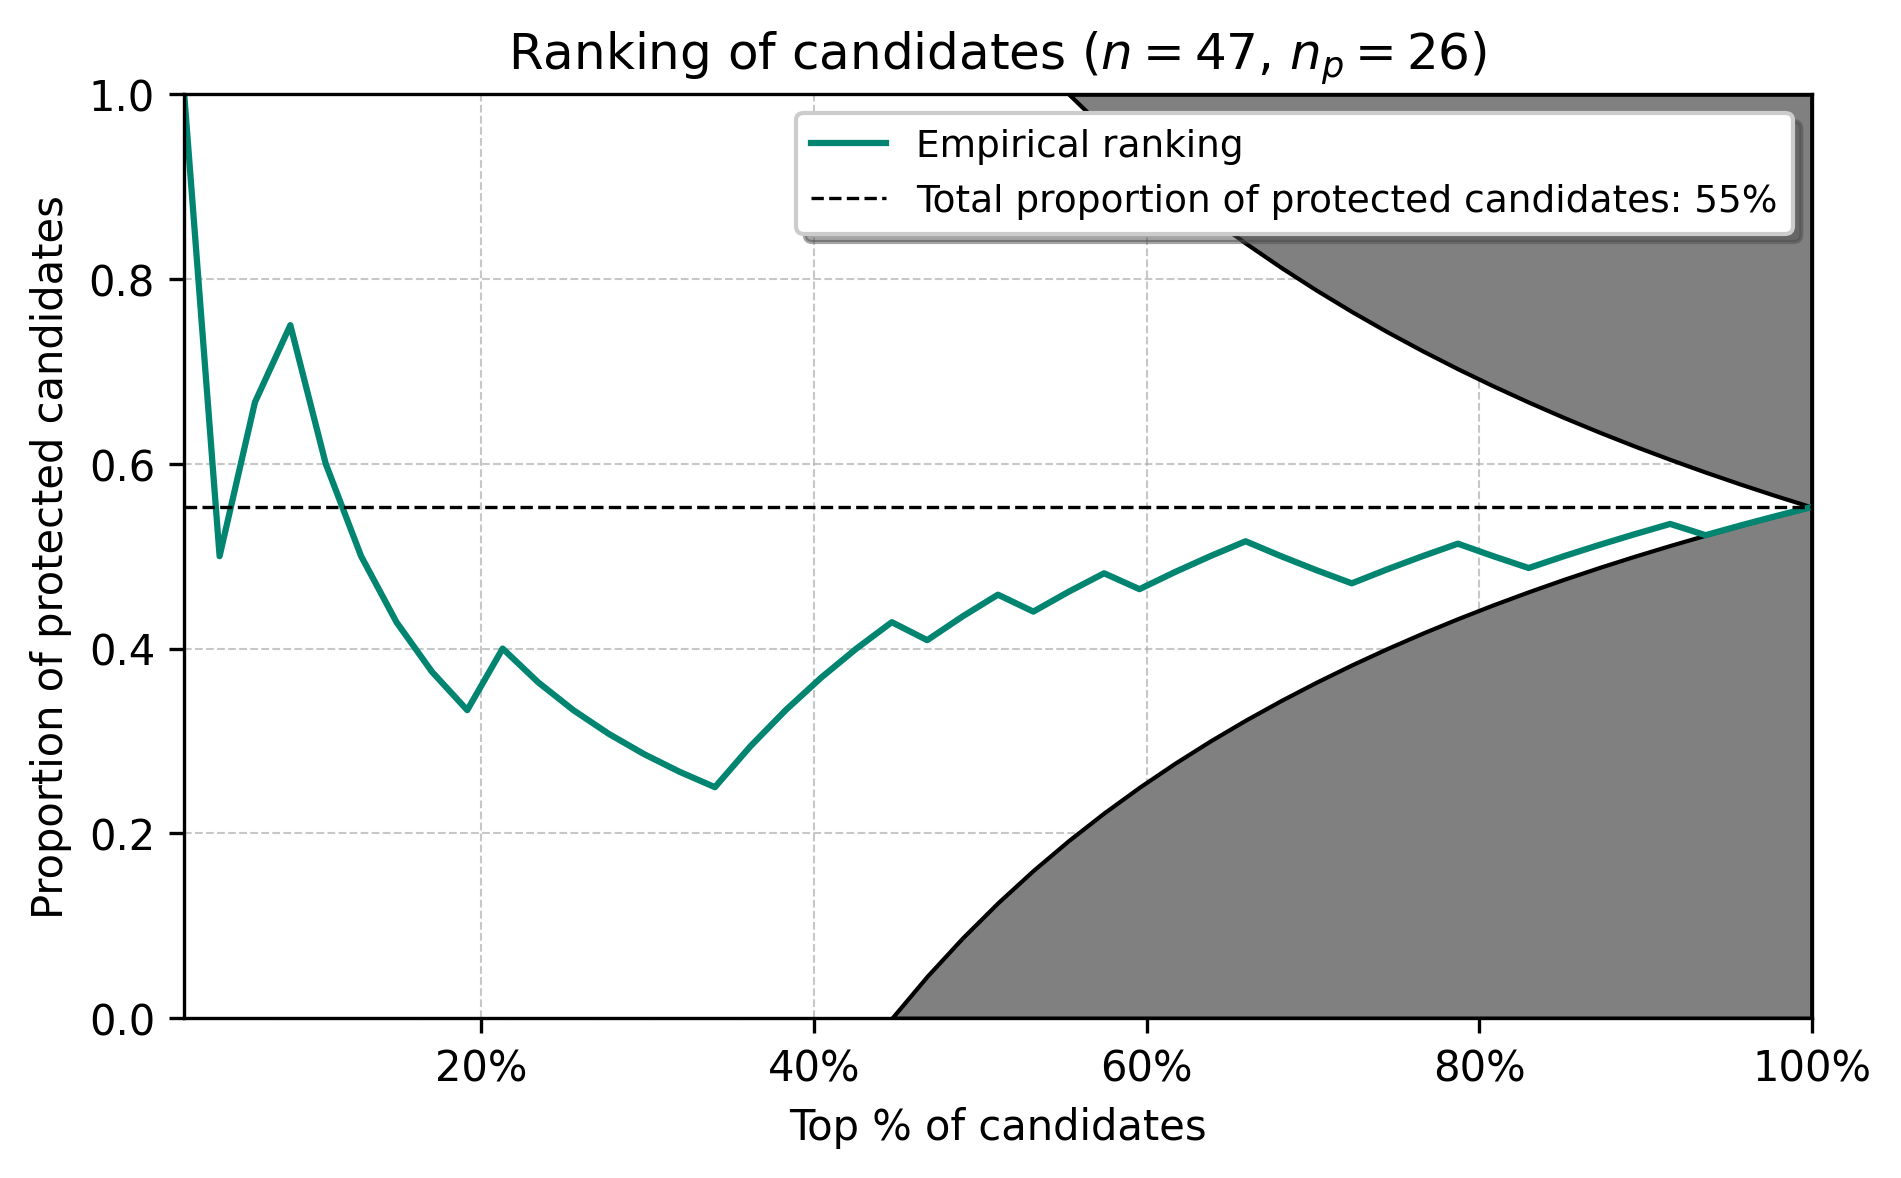

In [3]:
plot_ranking(x, ax=None)

### Single fairness test
Now, we want to perform a single fairness test (see Section 3.1) on the first `k` positions of the ranking.
For this goal, we use the `measure_fairness_single_point` function.

We set `k=30`, i.e. we want to test whether the number of protected candidates in the first 30 positions could plausibly be the result of random selection. Specifically, we want to find out whether the protected group is under-represented in the [1:30] subset, so we set `test_side='lower'`.

To test this, we set `alpha=0.05`, which means that we set the significance level of the hypergeometric test to $5\%$.

We also print the outcome of the test and plot the result, by setting `verbose=True, plot=True`.

The number of protected candidates in the top 30 positions is 15.
Fail to reject null hypothesis at position 30 with p-value 0.2527


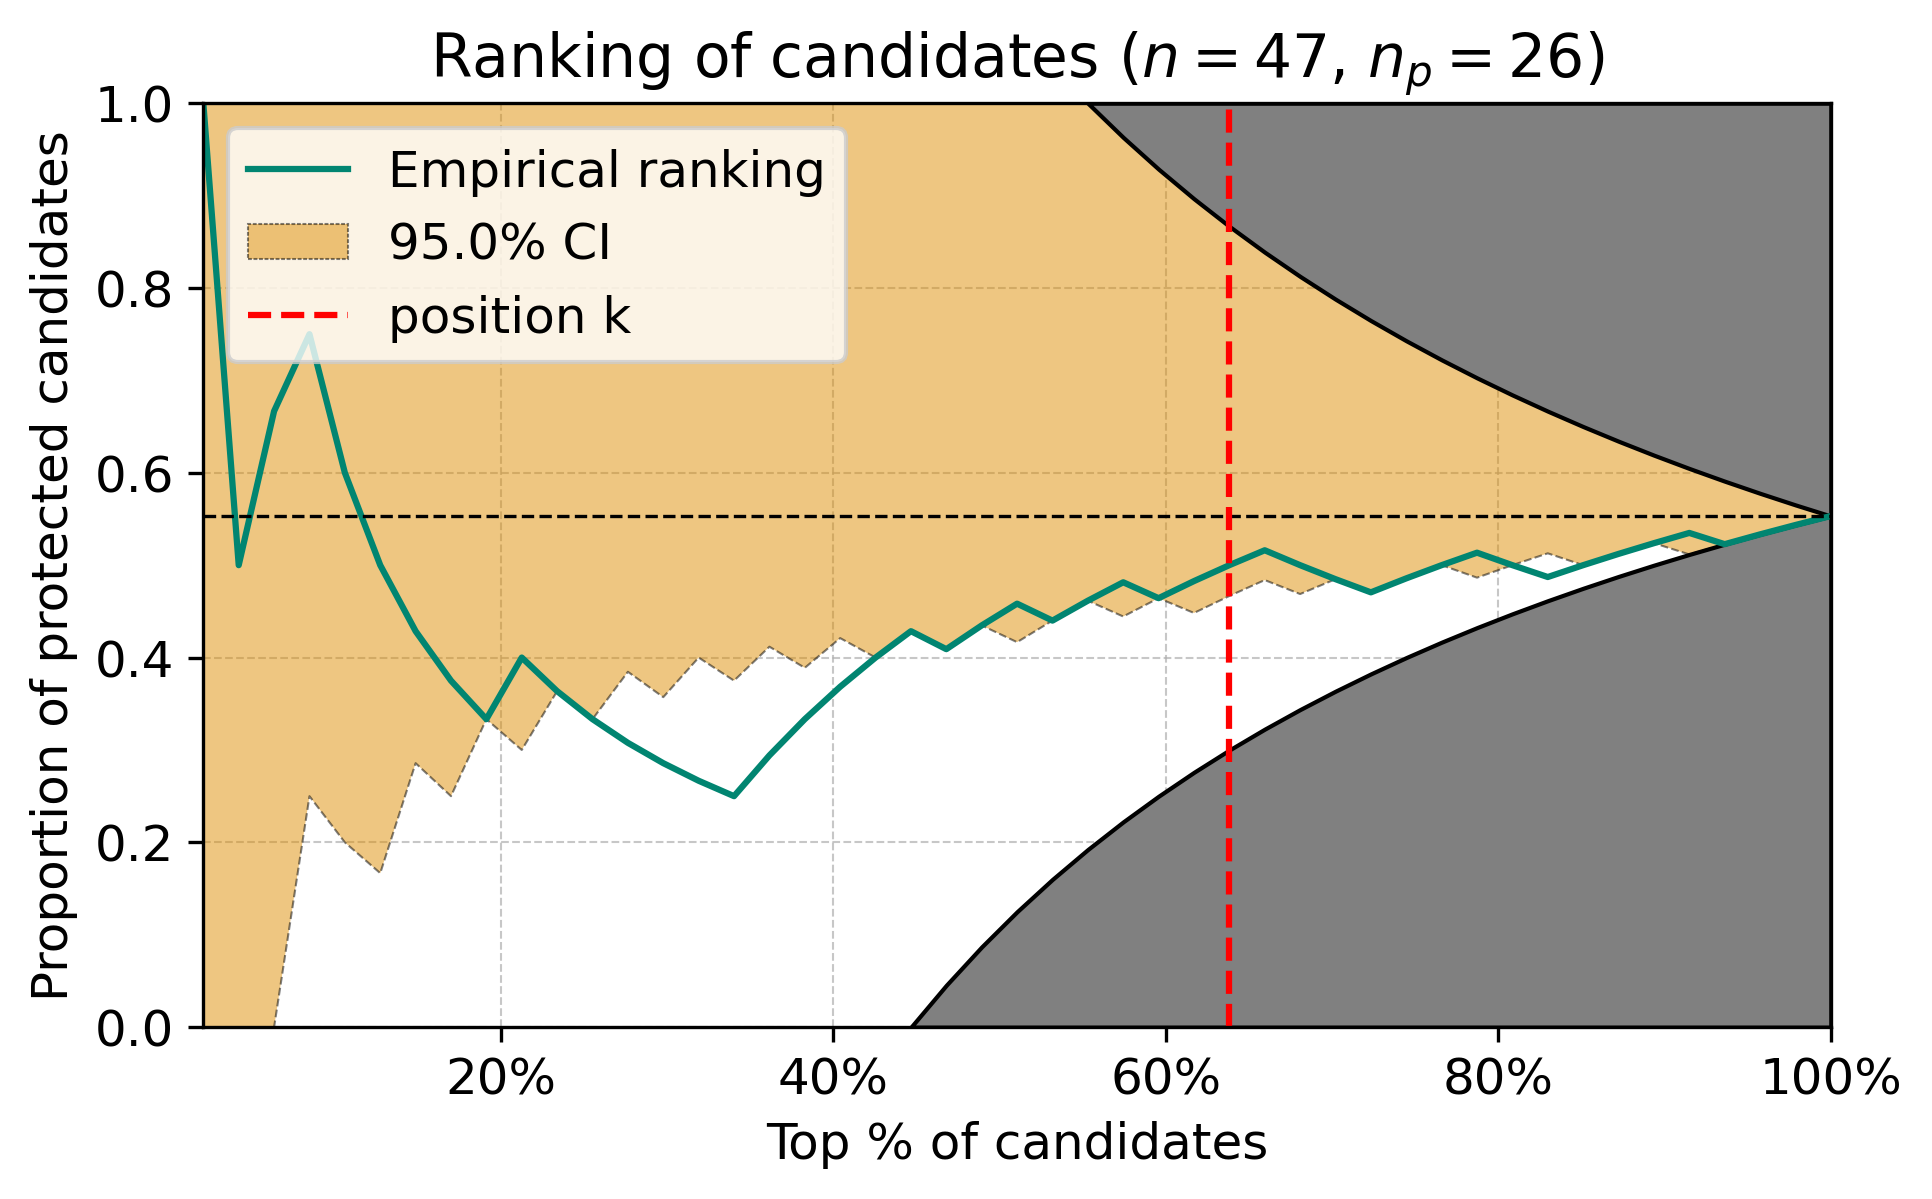

In [4]:
# Let's set k to 30 and alpha to 0.05
k = 30	
alpha = 0.05
print(f"The number of protected candidates in the top {k} positions is {sum(x[:k])}.")

# Measure fairness for a single point
_ = measure_fairness_single_point(x_seq=x, k=k, alpha=alpha, test_side='lower', verbose=True, plot=True)

As we can see from the printed output, the p-value is $25.27\%$, which means that we fail to reject the unfairness of the ranking.
It follows that the protected group is not under-represented in this case.

We can see the same result also by looking at the plot: at position $30$, the green line is inside the $95\%$ confidence interval, and therefore we cannot flag the ranking as unfair with significance of $5\%$.

### Multiple tests
From the previous plot, it looks like although the ranking is fair for `k=30`, the group was under-represented in previous positions. To test this, it is useful to see whether the protected group was under-represented across all the [1:j] subsets of the ranking, for $j=1,\dots,k$.

To this end, we perform $30$ tests on the first $30$ subsets, by using the `measure_fairness_multiple_points` function.
We keep the same parameters as before. Because of the dependencies of the tests, we cannot perform this task analytically, and we rely instead on Monte Carlo simulations (for details, see Section 3.2). For this example, we set the number of simulations to `n_exp=1000000`.

Reject null hypothesis with p-value 0.0124


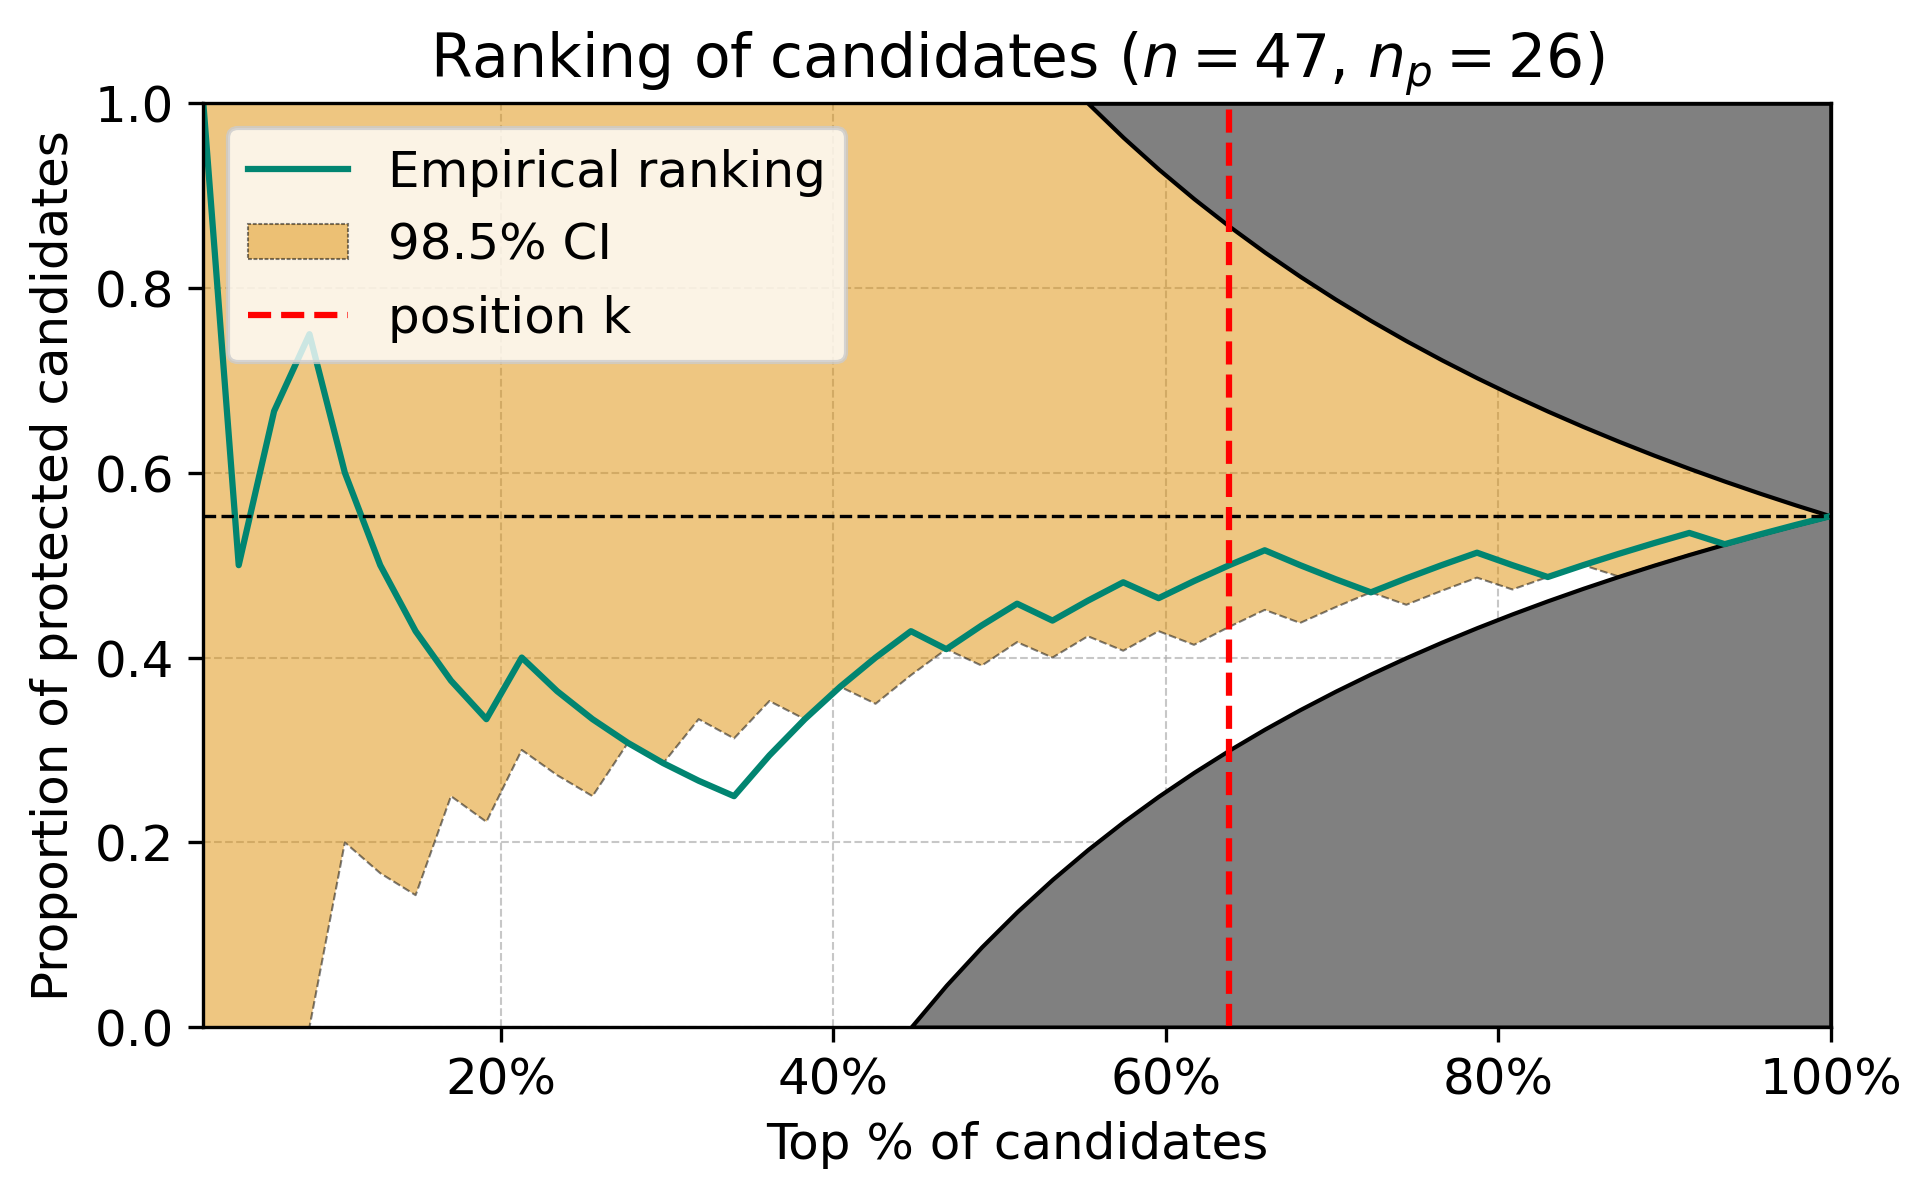

In [5]:
random_seed = 42

n_exp = 1_000_000
_, generatedData = measure_fairness_multiple_points(x_seq=x, k=k, alpha=alpha, test_side='lower', n_exp=n_exp, verbose=True, plot=True, seed=random_seed)

The outcome in this case is that we reject the hypothesis of random selection, meaning that we flag the ranking as unfair, and specifically we affirm that the protected group is under-represented.

Since we performed $30$ tests, we needed to find an adjusted signifance level to control the family-wise error rate among all tests at level $\alpha=5\%$. The adjusted parameter, $\alpha_c$, is equal to $1.5\%$, and our function directly plots the corresponding confidence interval. Visually, this means that if the ranking falls below the confidence interval at any point in the first $30$ subsets, we will flag the ranking as unfair.

### Re-ranking

Since our ranking has been flagged as unfair, we can use the re-ranking algorithm to adjust the original ranking and improve fairness.

We do this using the `adjust_ranking` function. We pass the same parameters as before, along with the `ids` array to keep track of the item identifiers and their new positions after re-ranking.

Note that we also provide the `generatedData` object obtained from the previous fairness test. This allows us to reuse the Monte Carlo simulation results, making the re-ranking process more efficient.

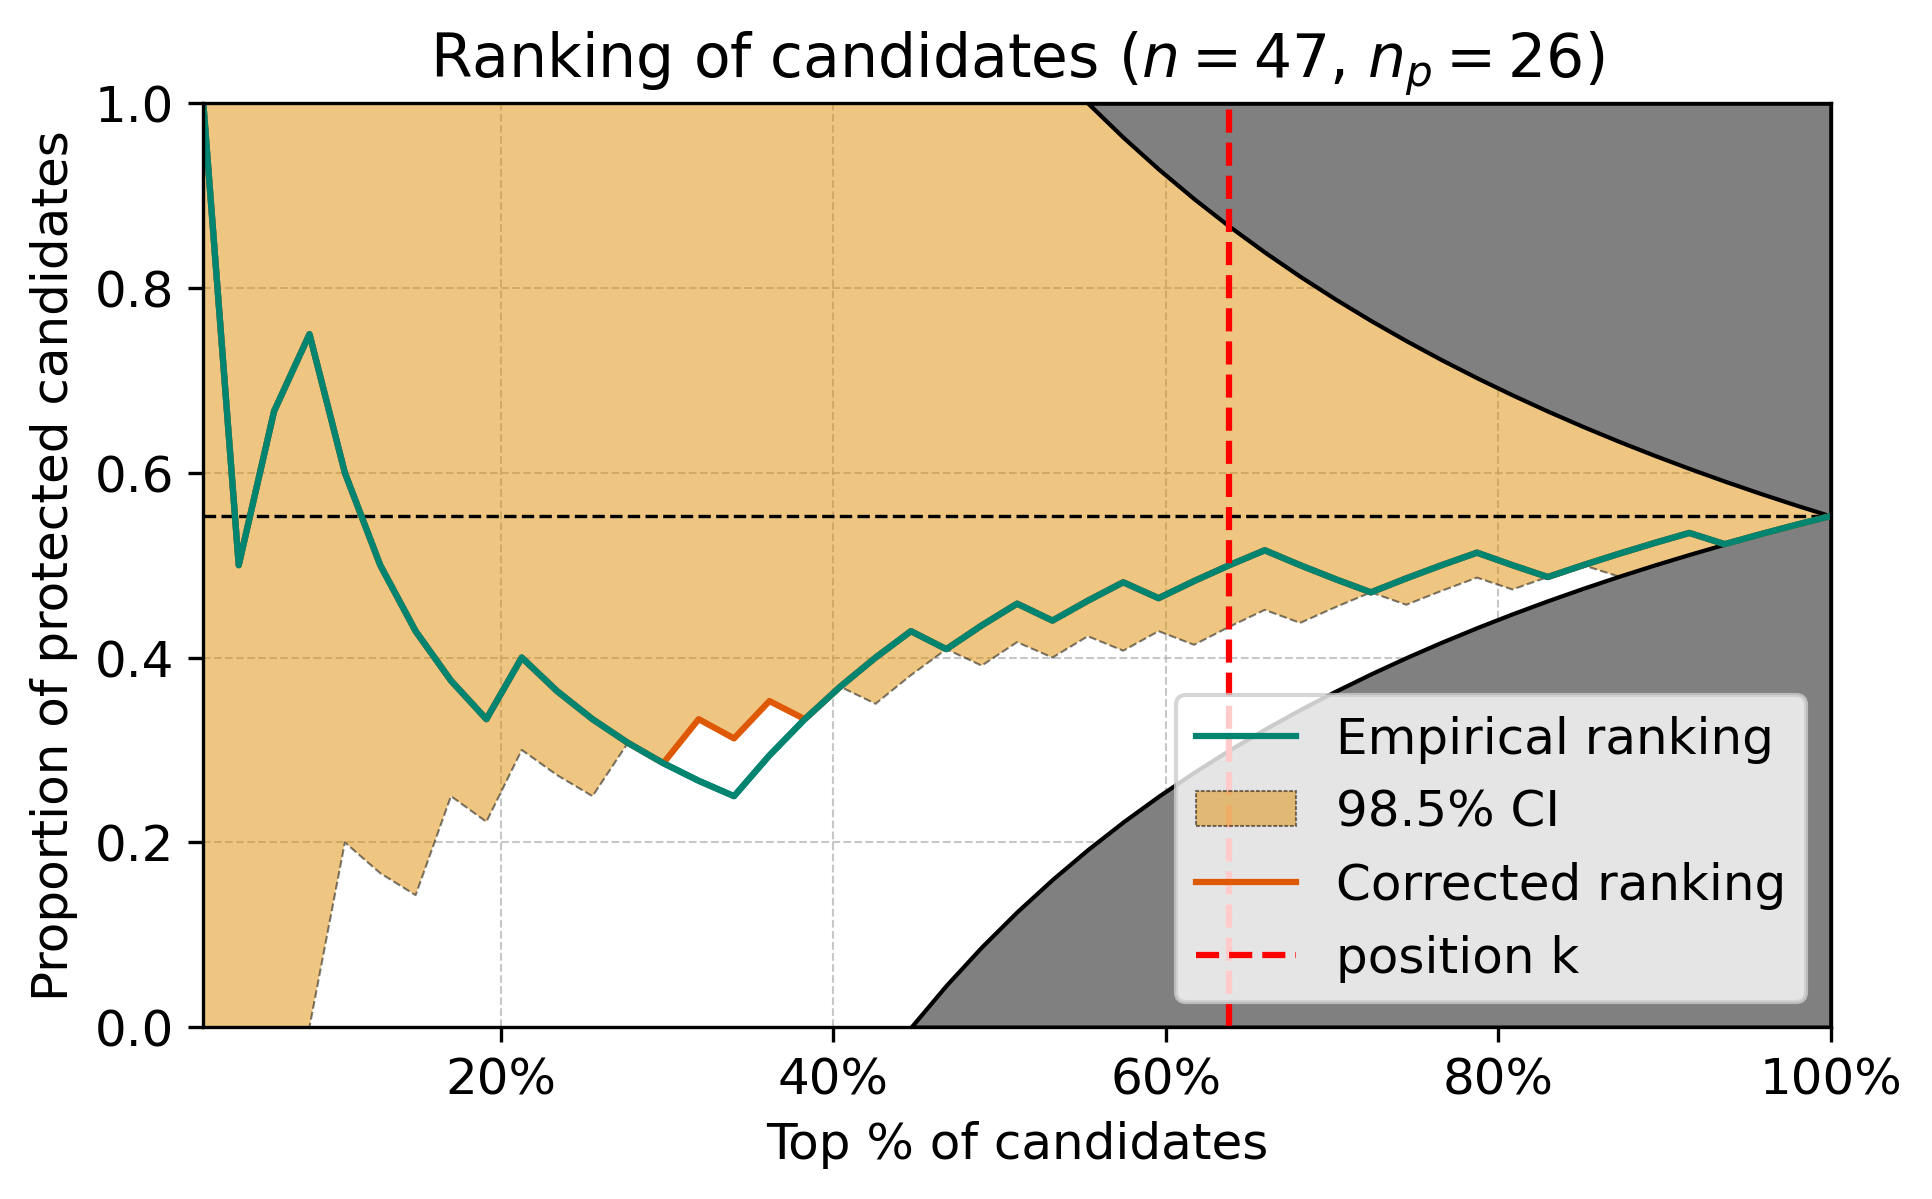

In [6]:
corrected_x, corrected_ids, _ = adjust_ranking(x_seq=x, ids=ids, k=k, alpha=alpha, generatedData=generatedData, test_side='lower', n_exp=n_exp, plot=True, seed=random_seed)

### Other functionalities
We can change the type of the test we do. The three options are:
- `test_side='lower'` to test for under-representation;
- `test_side='upper'` to test for upper-representation;
- `test_side='two-sided'` to perform a two-sided test, meaning that we want to test whether the representation of the protected and non-protected groups is balanced.

If we perform a two-sided test, the result is the following:

Reject null hypothesis with p-value 0.0243


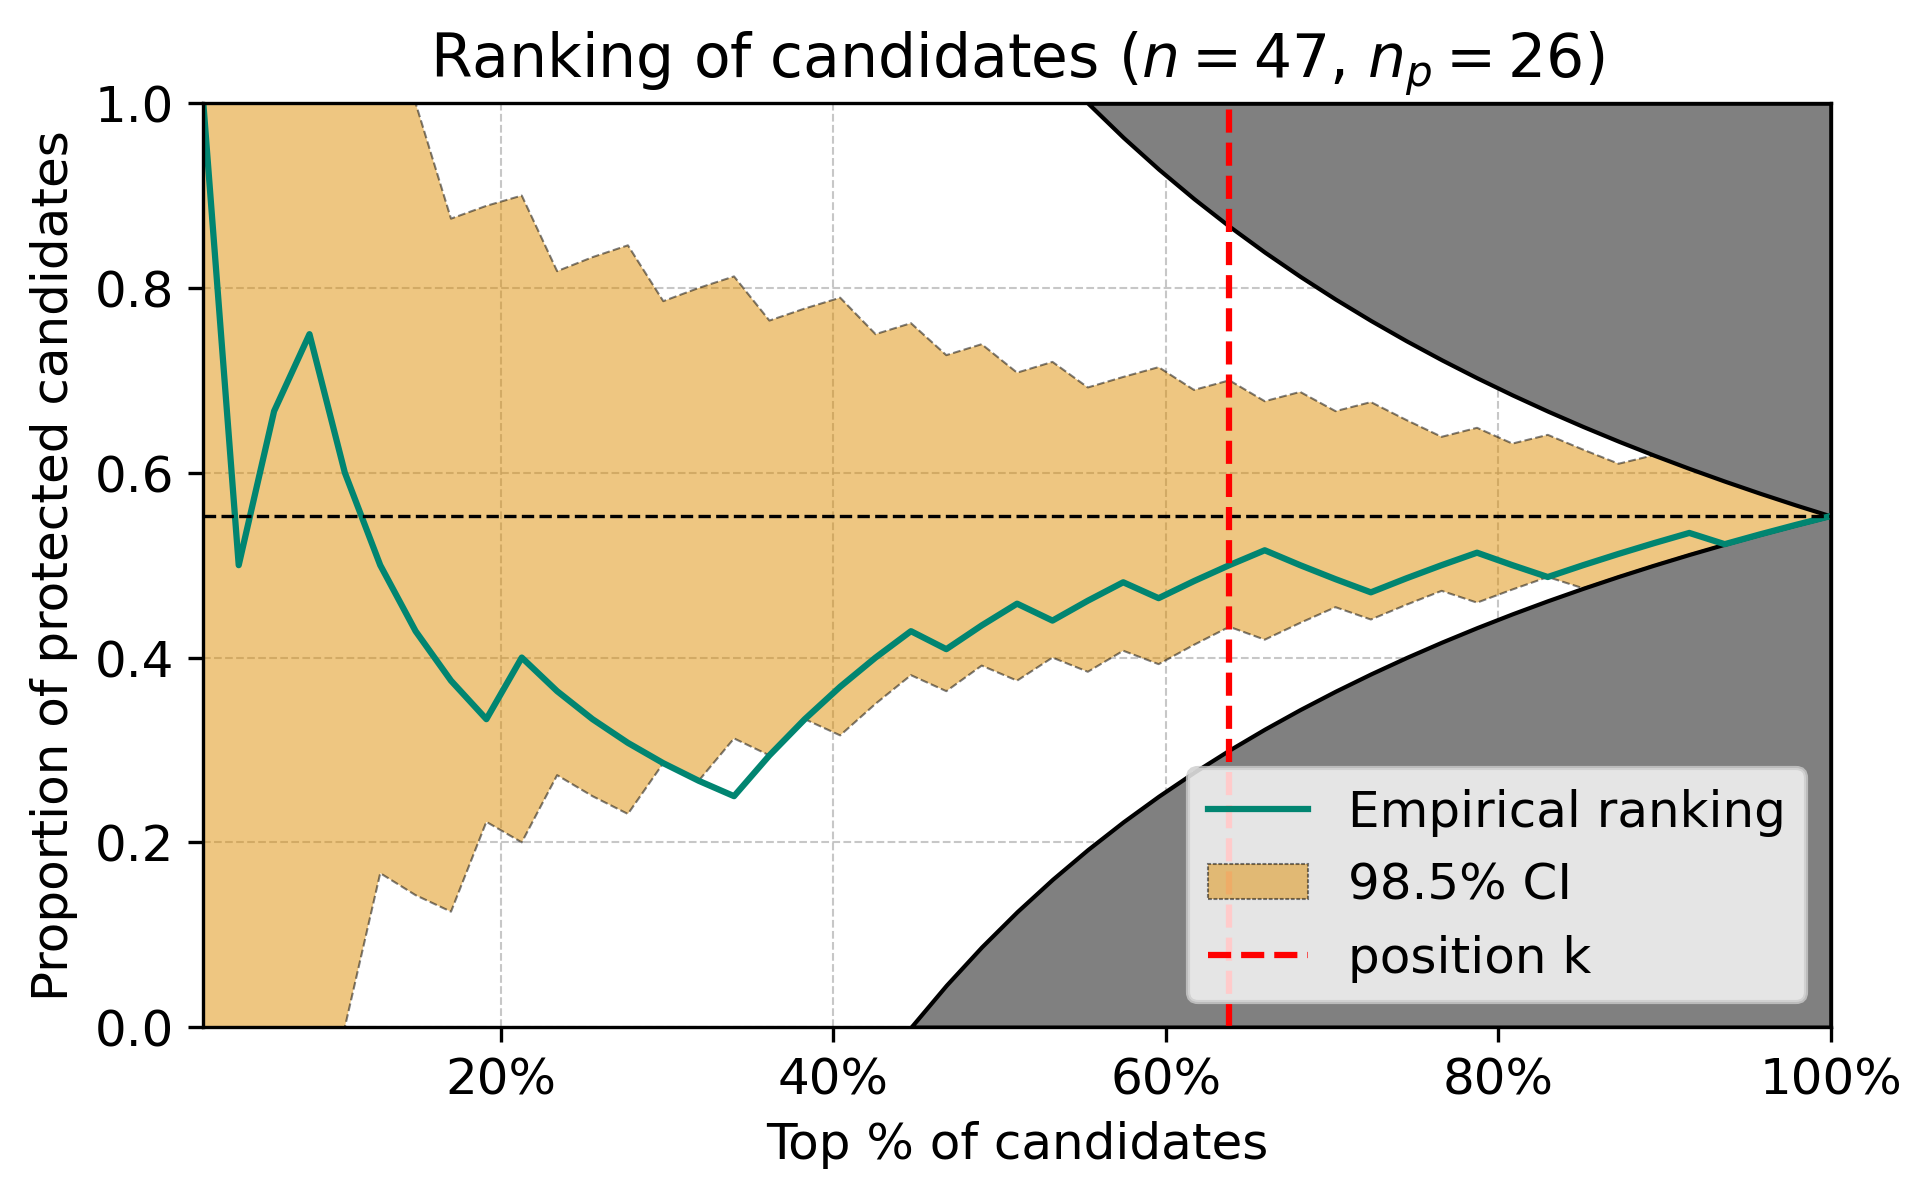

In [7]:
_ = measure_fairness_multiple_points(x_seq=x, k=k, alpha=alpha, test_side='two-sided', n_exp=n_exp, verbose=True, plot=True, seed=random_seed)

Additionally, we can also perform a sampling where the protected and non-protected groups have different odds of being sampled (see Section 4.2). The so called odd-ratio, i.e. the relative likelihood of picking a protected candidate rather than a non-protected one, is determined by the variable `omega` (the default value is 1).

To choose the desired level of `omega`, sometimes we want to start from a desired proportion instead, that we call `rho`. This value represents the probability of selecting a protected candidate over a non-protected candidate in the first draw, i.e. when all groups are full. To switch from one formulation to another, we design the `from_target_proportion_to_omega` function, showcased below:

In [8]:
def from_target_proportion_to_omega(rho, n, n_protected):
    p = n_protected/n
    return (rho*(1-p))/((1-rho)*p)

Let us now perform a two-sided test with odds ratio equal to $0.5$. To showcase the expected behaviour of the proportion of protected candidates for this odds ratio, we can use the `plot_only_ci` function.

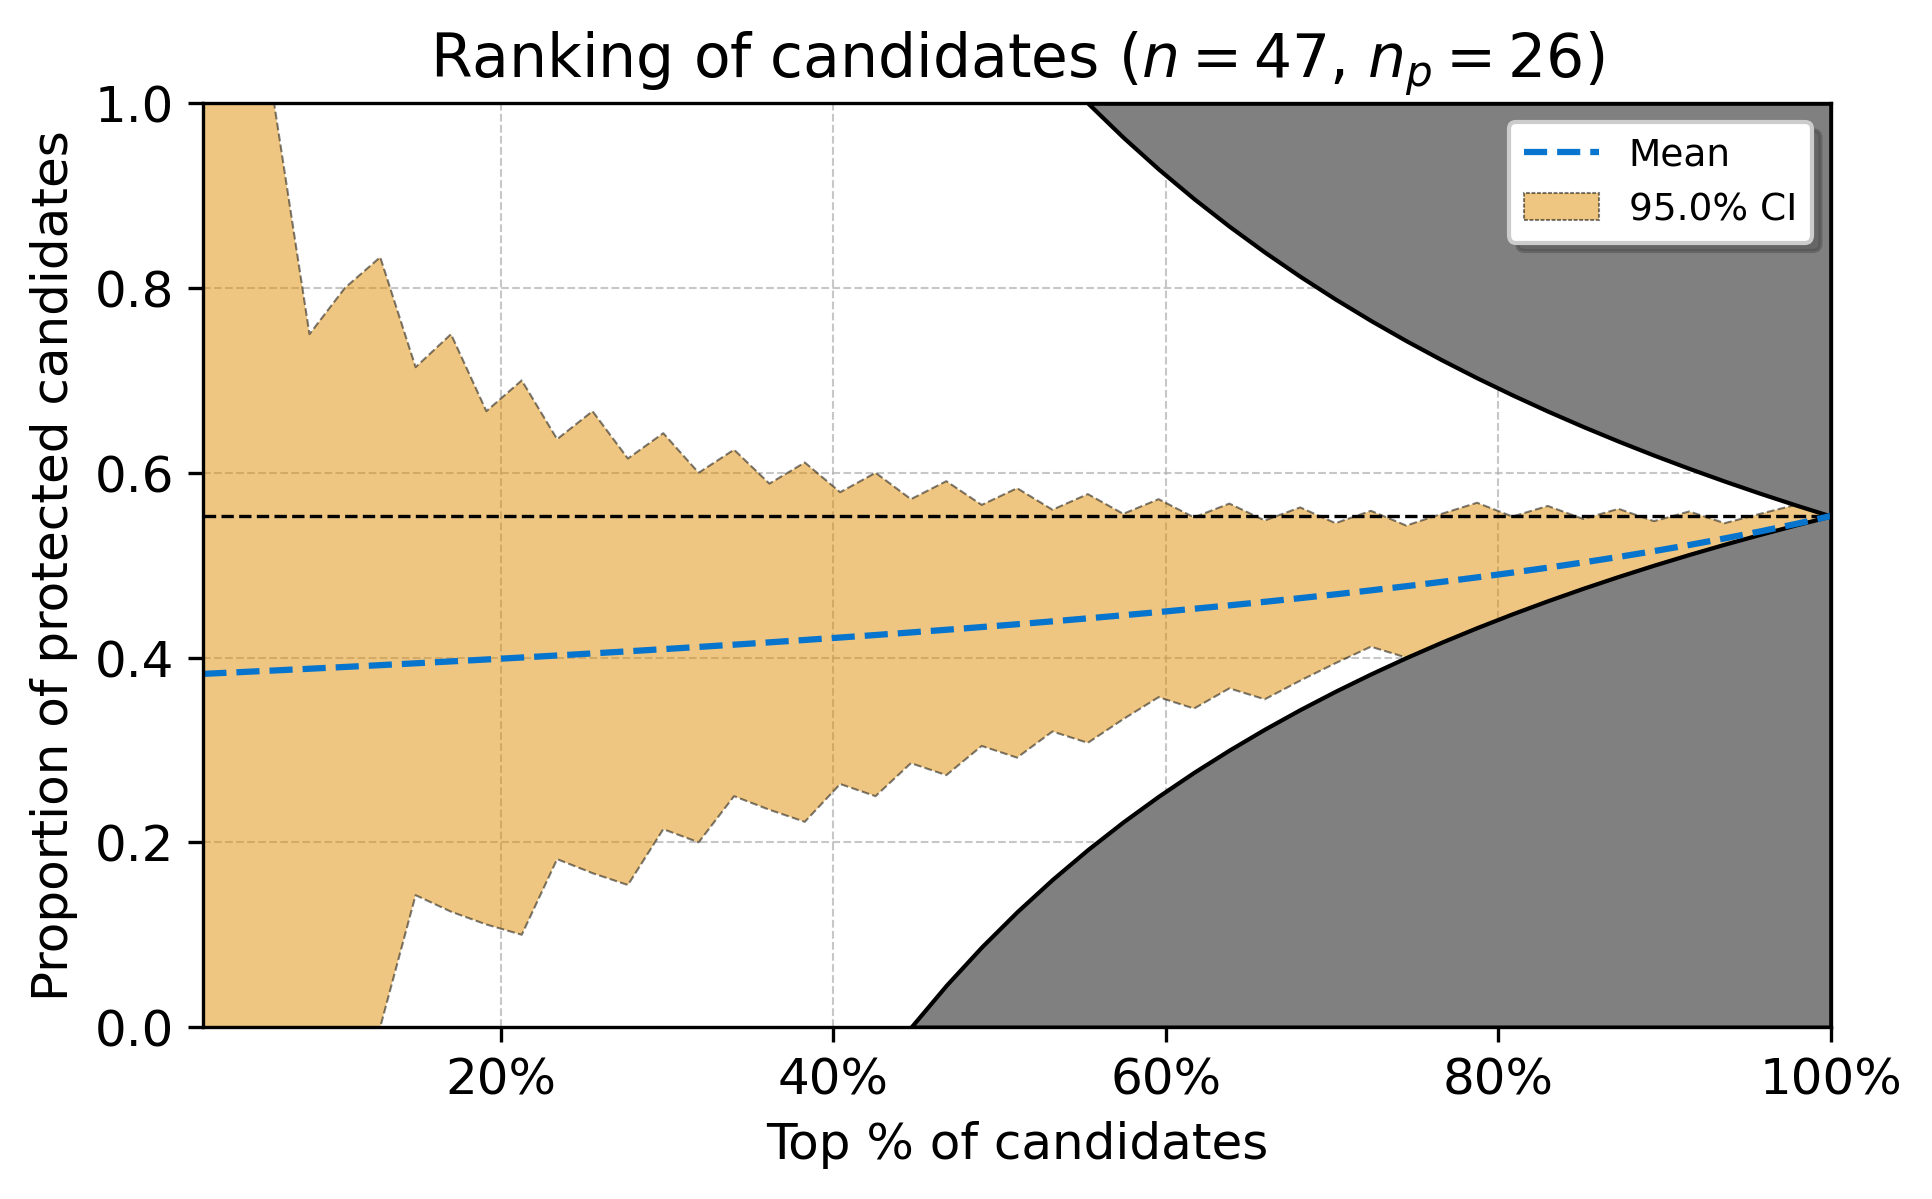

In [9]:
omega = 0.5
plot_only_ci(n=len(x), n_protected=int(sum(x)), alpha=alpha, ci='two-sided', omega=omega, ax=None)

If we perform the test we obtain:

Fail to reject null hypothesis with p-value 0.4931


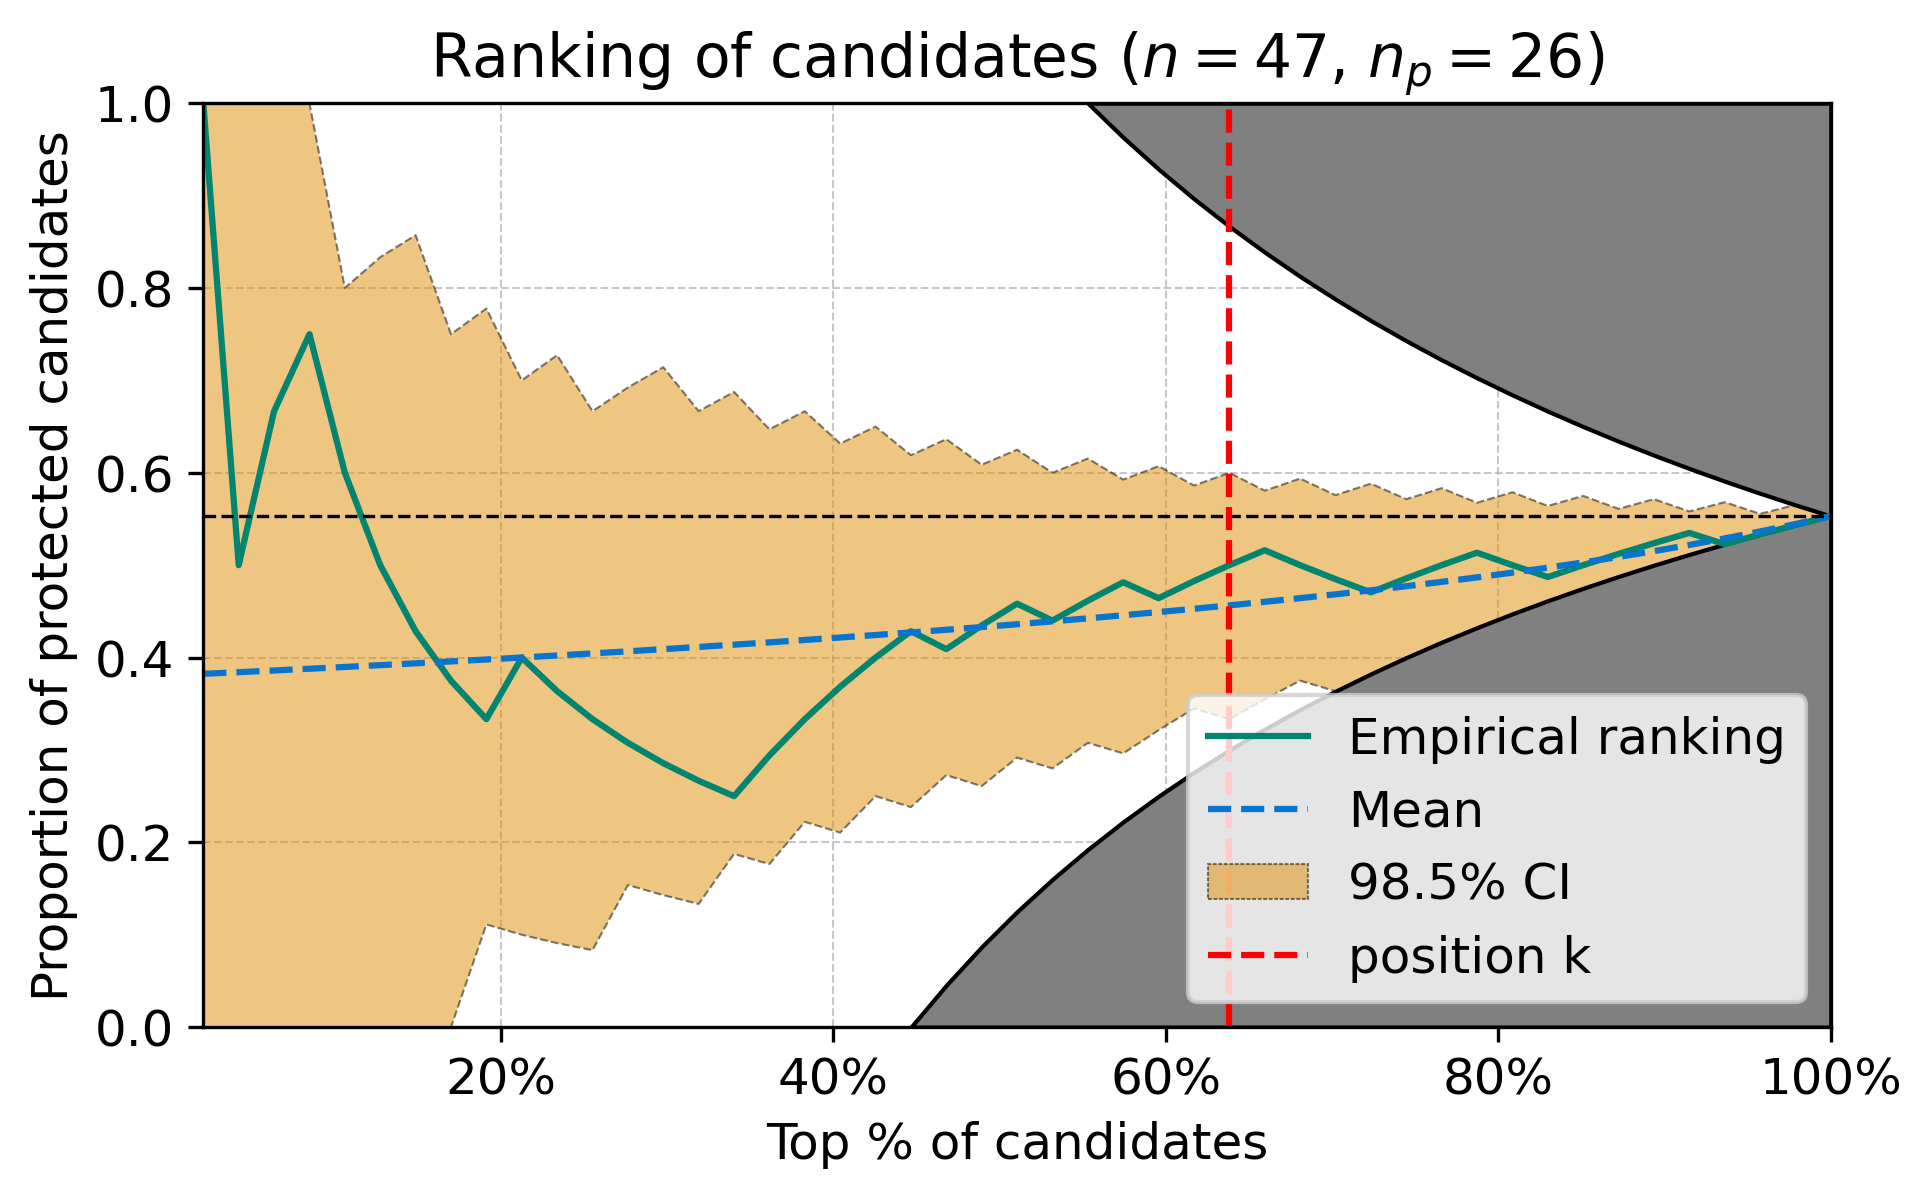

In [10]:
_ = measure_fairness_multiple_points(x_seq=x, k=k, alpha=alpha, omega=omega, test_side='two-sided', n_exp=n_exp, verbose=True, plot=True, seed=random_seed)

If you have any question or notice a bug, please reach out to cartiervandissel@csh.ac.at .